***
## **<center>Predicting Book Award Candidates from Goodreads Data</center>**

### <center> **IST718 Final Project</center>**

**<center>Jon Kaplan, Luke Miller, John Fields | June 13, 2020</center>**
***

<br>

Insert summary here...

Based on work by:
* Sebastien David - https://github.com/sjd1882
* University of California San Diego BookGraph - https://sites.google.com/eng.ucsd.edu/ucsdbookgraph


# 1. Import Packages

***

In [0]:
import pandas as pd
import numpy as np
import os
import json
import csv
from scipy.stats import uniform
import logging
pd.options.display.max_columns=None

In [3]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install the Goodreads API package

Install the Goodreads API package

In [1]:
!pip install Goodreads

     |████████████████████████████████| 163kB 3.8MB/s 
  Created wheel for Goodreads: filename=goodreads-0.3.2-cp36-none-any.whl size=13118 sha256=8d27ece098961bac47950b3049f2aa029839ca903a202d6dd414f6c4945c7257
  Stored in directory: /root/.cache/pip/wheels/70/10/60/95c53185e3b96fa8da290cefe495d5eef298734b7d7f634e72
  Created wheel for rauth: filename=rauth-0.7.3-cp36-none-any.whl size=16055 sha256=a0a6a4b1f7f8ce7df3411f71f619a70498a485683815c0c6c381b5396e22030a
  Stored in directory: /root/.cache/pip/wheels/7b/94/5d/81afc278dd5da884a0002563dc4b0fe85f9067a5a40f76f858
Successfully built Goodreads rauth


In [0]:
#Please do not post these keys publicly unless the Goodreads keys below are removed
from goodreads import client
gc = client.GoodreadsClient("nCr2RoNWpqXn1nLVpyLFww", "EFksSGXqxT5HgtrSYHqHzHbvAJEkclOF5RuCgGtBqM")

In [0]:
#To access some of the methods, you need OAuth for authorization.
gc.authenticate("nCr2RoNWpqXn1nLVpyLFww", "EFksSGXqxT5HgtrSYHqHzHbvAJEkclOF5RuCgGtBqM")

In [0]:
#Show the output from multiple command line calls (used in code cell below)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
#Once you have the GoodreadsBook instance for the book, you can access data for the queried book.
book = gc.book(1)
book.title
authors = book.authors
authors[0].name
book.average_rating

'Harry Potter and the Half-Blood Prince (Harry Potter, #6)'

'J.K. Rowling'

'4.57'

In [6]:
#Access the works count for an author
author = gc.author(2617)
author.name
author.works_count
author.books

'Jonathan Safran Foer'

'54'

[Extremely Loud & Incredibly Close,
 Everything Is Illuminated,
 Eating Animals,
 Here I Am,
 We Are the Weather: Saving the Planet Begins at Breakfast,
 Tree of Codes,
 Everything is Illuminated & Extremely Loud and Incredibly Close,
 The Unabridged Pocketbook of Lightning,
 A Convergence of Birds: Original Fiction and Poetry Inspired by Joseph Cornell,
 The Future Dictionary of America]

#Install Apache Spark on Colab


In [0]:
# #If Spark doesn't work with version 2.3.4, the links to version 3.0.0-preview2 are provided below.  There are known issues with 2.4.5.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://www-us.apache.org/dist/spark/spark-2.3.4/spark-2.3.4-bin-hadoop2.7.tgz
# #!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
# #!wget -q https://www-us.apache.org/dist/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop2.7.tgz

!tar xf spark-2.3.4-bin-hadoop2.7.tgz
# #!tar xf spark-2.4.5-bin-hadoop2.7.tgz
# #!tar xf spark-3.0.0-preview2-bin-hadoop2.7.tgz

!pip install -q findspark

In [0]:
# import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

os.environ["SPARK_HOME"] = "/content/spark-2.3.4-bin-hadoop2.7"
# #os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
# #os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop2.7"

The previous code cell install Apache Spark (and its dependencies such as Java JDK 8) for use in Google Colab. Once the Google Colab Session terminates, the following cell must be run again.

**Launch Spark Session on Colab**

In [7]:
# Findspark for Jupyter Notebook (spark-2.4.4-bin-hadoop2.7)
import findspark
findspark.init()

# Start Apache Spark Session & Context
import pyspark
from pyspark.sql import SQLContext

sc = pyspark.SparkContext(appName='sd701-RecoSys-Models')
sqlContext = SQLContext(sc)

print('Master : ', sc.master)
print('Cores  : ', sc.defaultParallelism)

Master :  local[*]
Cores  :  4


In [0]:
# Required Later
sqlContext.sparkSession.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

**Packages**

Only the following packages are available in Google Colab:

In [9]:
!pip install koalas

In [10]:
#If you encounter issues running Spark in Colab, try restarting the Runtime and run this code block to install Pyarrow 0.15.
!pip install pyarrow==0.15.*

In [11]:
#Default Packages (available by Default in Google Colab)
import math
import databricks.koalas as ks
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import random
from pprint import pprint
from matplotlib.lines import Line2D
import json
from bs4 import BeautifulSoup
import urllib.request
import time
import logging

# Downloaded Packages (not available by Default)
import databricks.koalas

# PySpark Utilities
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics

# Random Seed
SEED = 1234

# Set-up
plt.style.use('seaborn')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data - Spark

In [0]:
#WARNING: THIS CODE CELL RUNS FOR ABOUT 6 MINUTES TO LOAD 2 MILLION BOOKS AND 15 MILLION REVIEWS - UNCOMMENT TO LOAD ALL
booksSpark = sqlContext.read.json ("/content/drive/My Drive/Colab Notebooks/IST718/Final Project/UCSDBookGraph/goodreads_books.json")
reviewsSpark = sqlContext.read.json ("/content/drive/My Drive/Colab Notebooks/IST718/Final Project/UCSDBookGraph/goodreads_reviews_spoiler.json")

In [14]:
booksSpark.head(10)

[Row(asin='', authors=[Row(author_id='604031', role='')], average_rating='4.00', book_id='5333265', country_code='US', description='', edition_information='', format='Paperback', image_url='https://images.gr-assets.com/books/1310220028m/5333265.jpg', is_ebook='false', isbn='0312853122', isbn13='9780312853129', kindle_asin='', language_code='', link='https://www.goodreads.com/book/show/5333265-w-c-fields', num_pages='256', popular_shelves=[Row(count='3', name='to-read'), Row(count='1', name='p'), Row(count='1', name='collection'), Row(count='1', name='w-c-fields'), Row(count='1', name='biography')], publication_day='1', publication_month='9', publication_year='1984', publisher="St. Martin's Press", ratings_count='3', series=[], similar_books=[], text_reviews_count='1', title='W.C. Fields: A Life on Film', title_without_series='W.C. Fields: A Life on Film', url='https://www.goodreads.com/book/show/5333265-w-c-fields', work_id='5400751'),
 Row(asin='', authors=[Row(author_id='626222', rol

In [0]:
# The preprocessing is not working because the function above need to be re-written.
#Data Preprocessing
#GoodreadsDatasets = GoodreadsDatasets(ratings=ratings, 
                                      #books=books,
                                      #awards=awards,
                                      #genres=genres,
                                      #links=links,
                                      #personalRatings=personal,
                                      #debug=debug)                  



In [0]:
#GoodreadsDatasets.preprocessing()
# dfRatings = GoodreadsDatasets.get_ratings() 
# dfBooks = GoodreadsDatasets.get_books()
# dfAwards = GoodreadsDatasets.get_awards()
# dfGenres = GoodreadsDatasets.get_genres()

#dfRatingsFP = ratingsFP
#dfBooks = books
#dfAwards = awards
#dfGenres = genres
#dfBooksFP = booksFP

# Exploratory Data Analysis with Koalas

Koalas is a Python library that provides a "Pandas-like API" on top of a Spark DataFrame.

[GitHub Repository of Koalas](https://github.com/databricks/koalas)

https://koalas.readthedocs.io/en/latest/getting_started/10min.html

BooksSpark EDA

In [16]:
booksSpark.columns

['asin',
 'authors',
 'average_rating',
 'book_id',
 'country_code',
 'description',
 'edition_information',
 'format',
 'image_url',
 'is_ebook',
 'isbn',
 'isbn13',
 'kindle_asin',
 'language_code',
 'link',
 'num_pages',
 'popular_shelves',
 'publication_day',
 'publication_month',
 'publication_year',
 'publisher',
 'ratings_count',
 'series',
 'similar_books',
 'text_reviews_count',
 'title',
 'title_without_series',
 'url',
 'work_id']

In [17]:
booksSpark.select("popular_shelves").show(10)

+--------------------+
|     popular_shelves|
+--------------------+
|[[3, to-read], [1...|
|[[2634, to-read],...|
|[[58, to-read], [...|
|[[7615, to-read],...|
|[[32, to-read], [...|
|[[56, to-read], [...|
|[[14, to-read], [...|
|[[515, to-read], ...|
|[[4, to-read], [1...|
|[[961, to-read], ...|
+--------------------+
only showing top 10 rows



In [18]:
booksSpark.explain(4)

== Parsed Logical Plan ==
Relation[asin#6,authors#7,average_rating#8,book_id#9,country_code#10,description#11,edition_information#12,format#13,image_url#14,is_ebook#15,isbn#16,isbn13#17,kindle_asin#18,language_code#19,link#20,num_pages#21,popular_shelves#22,publication_day#23,publication_month#24,publication_year#25,publisher#26,ratings_count#27,series#28,similar_books#29,... 5 more fields] json

== Analyzed Logical Plan ==
asin: string, authors: array<struct<author_id:string,role:string>>, average_rating: string, book_id: string, country_code: string, description: string, edition_information: string, format: string, image_url: string, is_ebook: string, isbn: string, isbn13: string, kindle_asin: string, language_code: string, link: string, num_pages: string, popular_shelves: array<struct<count:string,name:string>>, publication_day: string, publication_month: string, publication_year: string, publisher: string, ratings_count: string, series: array<string>, similar_books: array<string>, 

In [22]:
reviewsSpark.printSchema() 

root
 |-- book_id: string (nullable = true)
 |-- has_spoiler: boolean (nullable = true)
 |-- rating: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- review_sentences: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- timestamp: string (nullable = true)
 |-- user_id: string (nullable = true)



In [0]:
reviewsKdf = reviewsSpark.to_koalas()

# Visualizations EDA

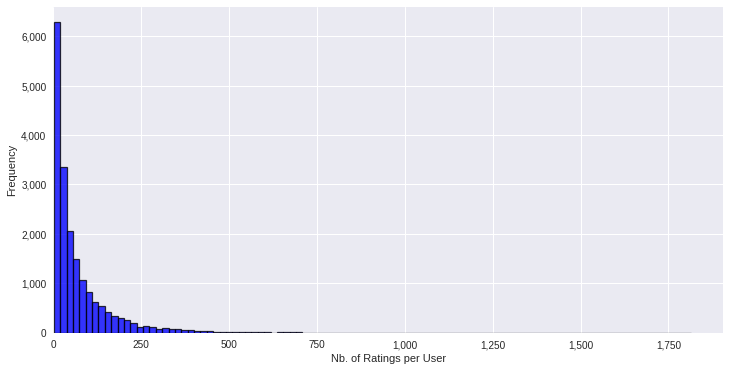

CPU times: user 341 ms, sys: 25.8 ms, total: 367 ms
Wall time: 13.6 s


In [24]:
%%time
f, ax = plt.subplots(figsize=(12,6))
userRatingGroup = reviewsKdf.groupby("user_id")['rating'].count()
userRatingGroup.hist(bins=100, color='blue', edgecolor='black',
                     linewidth=1.25, alpha=0.78, ax=ax)
ax.set_xlabel('Nb. of Ratings per User')
ax.set_xlim(0.0)
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

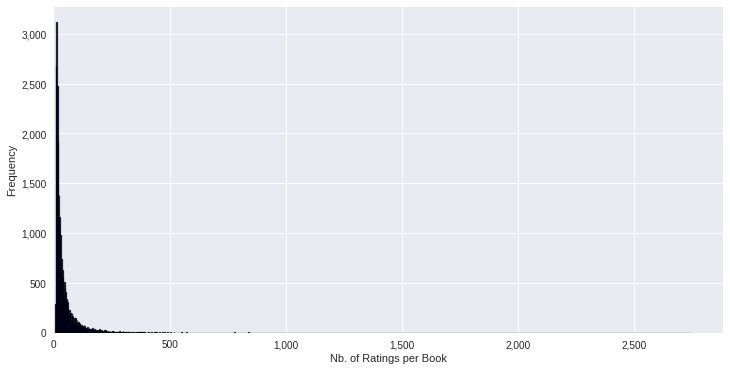

CPU times: user 1.52 s, sys: 41.9 ms, total: 1.57 s
Wall time: 13 s


In [25]:
%%time
f, ax = plt.subplots(figsize=(12,6))
bookRatingGroup = reviewsKdf.groupby("book_id")['rating'].count()
bookRatingGroup.hist(bins=1000, color='blue', edgecolor='black',
                      linewidth=1.25, alpha=0.78, ax=ax)
ax.set_xlabel('Nb. of Ratings per Book')
ax.set_xlim(0.0)
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

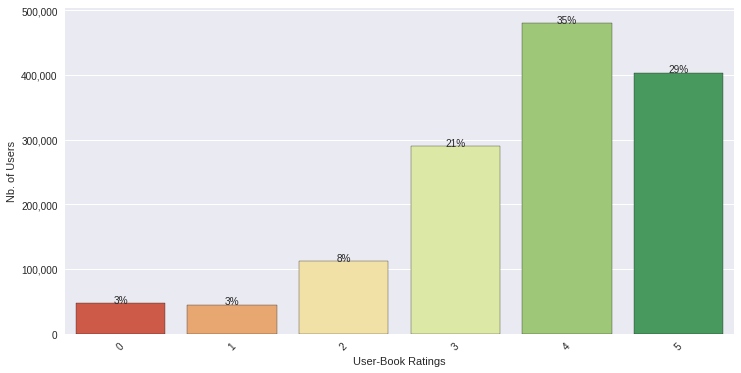

CPU times: user 172 ms, sys: 7.84 ms, total: 180 ms
Wall time: 5.29 s


In [26]:
%%time
bookRatingDistGroup = reviewsKdf['rating'].value_counts() \
                                             .sort_index() \
                                             .reset_index() \
                                             .to_pandas()

# Create Matplotlib Figure
fig, ax = plt.subplots(figsize=(12,6))

# Main Figure: Seaborn Barplot
sns.barplot(data=bookRatingDistGroup, x='index', y='rating',
            palette='RdYlGn', edgecolor="black", ax=ax)

# Set Xaxis and Yaxis
ax.set_xlabel("User-Book Ratings")
ax.set_ylabel('Nb. of Users')
ax.xaxis.set_tick_params(rotation=45)

# Thousand separator on Yaxis labels
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

# Add percentage text on top of each bar
total = float(bookRatingDistGroup['rating'].sum())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+350,
            '{0:.0%}'.format(height/total),
            ha="center") 

# Display plot
plt.show()

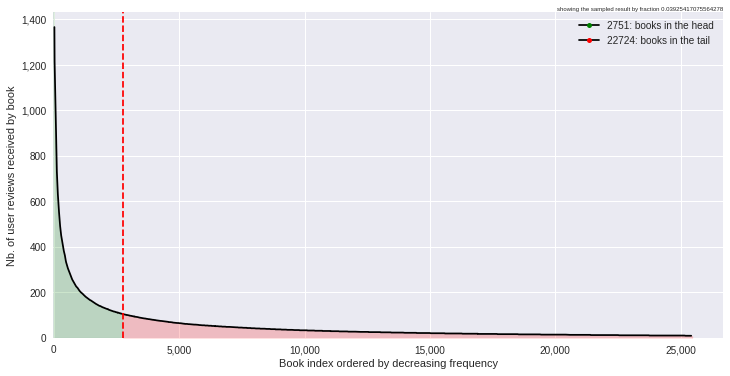

CPU times: user 688 ms, sys: 256 ms, total: 944 ms
Wall time: 58 s


In [28]:
%%time
f, ax = plt.subplots(figsize=(12,6))

# Calculate Cumulative Volumes
item_id_column = "book_id"
volume_df = reviewsKdf[item_id_column].value_counts().reset_index()
volume_df.columns = [item_id_column, "volume"]
volume_df[item_id_column] = volume_df[item_id_column].astype(str)
volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
volume_df['percent_of_total_volume'] = \
    volume_df['cumulative_volume']/volume_df['volume'].sum()

# Main
temp = volume_df['volume']
temp.plot(kind='line', ax=ax, color='black')

ax.set_xlim(-15)
ax.set_ylim(0.0)
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('Book index ordered by decreasing frequency')
ax.set_ylabel('Nb. of user reviews received by book')

# Plot vertical line at the tail location
percentage = 0.5
head = volume_df[volume_df.percent_of_total_volume <= percentage]
tail = volume_df[volume_df.percent_of_total_volume > percentage]
items_in_head = len(head)
items_in_tail = len(tail)

plt.axvline(x=items_in_head, color="red",  linestyle='--')

# Legend
legend_elements = [Line2D([0], [0], marker='o', color='black',
                          label=str(items_in_head)+': books in the head',
                          markerfacecolor='green', markersize=5),
                    
                    Line2D([0], [0], marker='o', color='black',
                          label=str(items_in_tail)+': books in the tail',
                          markerfacecolor='red', markersize=5)]
ax.legend(handles=legend_elements, loc=1)

# Fill area under plot
head = head.append(tail.head(1))
x1 = head.index.to_pandas().to_numpy() # => changes here from original code
y1 = head['volume'].to_pandas()        # => changes here from original code
x2 = tail.index.to_pandas().to_numpy() # => changes here from original code
y2 = tail['volume'].to_pandas()        # => changes here from original code
ax.fill_between(x1, y1, color="green", alpha=0.2)
ax.fill_between(x2, y2,  color="red", alpha=0.2)

plt.show()

# Simple Transformers Classification

In [29]:
%%writefile setup.sh

export CUDA_HOME=/usr/local/cuda-10.1
git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

Writing setup.sh


In [30]:
!sh setup.sh

Cloning into 'apex'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 6777 (delta 17), reused 8 (delta 5), pack-reused 6745
Receiving objects: 100% (6777/6777), 13.75 MiB | 7.40 MiB/s, done.
Resolving deltas: 100% (4525/4525), done.
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-wpku9ufh
Created temporary directory: /tmp/pip-req-tracker-7z1ikbvs
Created requirements tracker '/tmp/pip-req-tracker-7z1ikbvs'
Created temporary directory: /tmp/pip-install-nrj8d8qx
Processing ./apex
  Created temporary directory: /tmp/pip-req-build-eiga_oly
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-7z1ikbvs'
    Running setup.py (path:/t

In [31]:
!pip install simpletransformers

     |████████████████████████████████| 194kB 2.8MB/s 
     |████████████████████████████████| 3.8MB 8.9MB/s 
     |████████████████████████████████| 645kB 29.8MB/s 
     |████████████████████████████████| 204kB 44.3MB/s 
     |████████████████████████████████| 890kB 31.8MB/s 
     |████████████████████████████████| 1.1MB 47.1MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=d5444db1ae3ecc8c6290a6881727dbcc5d3a1d24e4759265c6f126877fc2b4e5
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=c3f2f8c172ee011dcfdfd170836e359f08ab257c540bcc0f11928e6c1cc15e3a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built seqeval sacremoses


In [32]:
!pip install -v --no-cache-dir apex/

Created temporary directory: /tmp/pip-ephem-wheel-cache-jpfyh3rs
Created temporary directory: /tmp/pip-req-tracker-dym0iczd
Created requirements tracker '/tmp/pip-req-tracker-dym0iczd'
Created temporary directory: /tmp/pip-install-y_ynt1ds
Processing ./apex
  Created temporary directory: /tmp/pip-req-build-bqj6fzwc
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-dym0iczd'
    Running setup.py (path:/tmp/pip-req-build-bqj6fzwc/setup.py) egg_info for package from file:///content/apex
    Running command python setup.py egg_info
    torch.__version__  =  1.5.0+cu101
    running egg_info
    creating /tmp/pip-req-build-bqj6fzwc/pip-egg-info/apex.egg-info
    writing /tmp/pip-req-build-bqj6fzwc/pip-egg-info/apex.egg-info/PKG-INFO
    writing dependency_links to /tmp/pip-req-build-bqj6fzwc/pip-egg-info/apex.egg-info/dependency_links.txt
    writing top-level names to /tmp/pip-req-build-bqj6fzwc/pip-egg-info/apex.egg-info/top_level.txt
    writing manifest file '/tmp/pip-r

In [33]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [0]:
from simpletransformers.classification import ClassificationModel

We want to use simpletransformers to implement the huggingface transformer methods

In [35]:
# fantasy paranormal books and reviews, along with gathered goodreads 
# hugo/nebula/locus nominees

nrows = 5000
bks = pd.read_csv('/content/drive/My Drive/Colab Notebooks/IST718/Final Project/UCSDBookGraph/booksFPawardsReviewsFPall.csv',
                  nrows=nrows,usecols=[1,3,22,23,33,34,35])
print(bks.head())

         isbn        asin  rating  \
0         NaN  B00071IKUY       3   
1         NaN  B00071IKUY       4   
2         NaN  B00071IKUY       3   
3  1934876569         NaN       3   
4         NaN  B01NCIKAQX       3   

                                         review_text award  Nominee  \
0  Competent. I'm sure I read the first half year...   NaN      NaN   
1  While these books are excellent overall, I thi...   NaN      NaN   
2  A collection of two novels about the mercenary...   NaN      NaN   
3  This was a really cute book, though to be hone...   NaN      NaN   
4  Lots and lots of filler. I was skimming toward...   NaN      NaN   

   Nominee_Winner  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  


In [38]:
#display(bks.head())
bks[['Nominee','Nominee_Winner']]=bks[['Nominee','Nominee_Winner']].fillna(0).astype(int)
bks.dtypes

isbn              object
asin              object
rating             int64
review_text       object
award             object
Nominee            int64
Nominee_Winner     int64
awardNominee       int64
dtype: object

We want a feature that is a 1 if there exists a matching entry in the awards data.

In [39]:
bks['awardNominee'] = bks['award'].notna().astype(int)
bksClass = bks[['isbn','asin','review_text','awardNominee']].rename(columns={'review_text':'text','awardNominee':'labels'})
bksClass = bksClass[bksClass['text'].notna()]
print(bksClass.head())

         isbn        asin                                               text  \
0         NaN  B00071IKUY  Competent. I'm sure I read the first half year...   
1         NaN  B00071IKUY  While these books are excellent overall, I thi...   
2         NaN  B00071IKUY  A collection of two novels about the mercenary...   
3  1934876569         NaN  This was a really cute book, though to be hone...   
4         NaN  B01NCIKAQX  Lots and lots of filler. I was skimming toward...   

   labels  
0       0  
1       0  
2       0  
3       0  
4       0  


## Minimal start

from https://simpletransformers.ai/docs/binary-classification/

In [40]:
randomSelection = np.random.rand(len(bksClass)) < 0.8
train_data = bksClass[randomSelection][['text','labels']]
test_data =  bksClass[~randomSelection][['text','labels']]
print('train {} rows'.format(len(train_data)))
print('test {} rows'.format(len(test_data)))

train 4000 rows
test 999 rows


In [41]:
train_data.dtypes

text      object
labels     int64
dtype: object

In [42]:
# Optional model configuration
model_args = {
    "num_train_epochs": 1,
    "sliding_window": True
}

# Create a ClassificationModel
model = ClassificationModel(
    "roberta", "roberta-base", args=model_args
)

# Train the model
model.train_model(train_data)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(test_data)


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 0.655821

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 1.002749Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 0.648805Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Running loss: 2.186972

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.020602



/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [43]:
print(result)
acc = (result['tp']+result['tn'])/(result['tp']+result['fp']+result['tn']+result['fn'])
print('Test accuracy is {}'.format(acc))

{'mcc': 0.0, 'tp': 0, 'tn': 935, 'fp': 0, 'fn': 64, 'eval_loss': 0.27201796438069953}
Test accuracy is 0.9359359359359359


## Predicting bigger data

reload but instead of 5,000 records let's go up to 50,000 using the model we just tuned.

## Load Saved Model

This is only needed if you want to evaluate without training. You can use a saved model from the 'outputs' folder that the train step uses. If you still have model loaded in memory you shouldn't run this.

In [0]:
model_args = {
    "num_train_epochs": 1,
    "sliding_window": True
}

# Create a ClassificationModel
model = ClassificationModel(
    "roberta", "/content/drive/My Drive/data/outputs", args=model_args
)

## Load more data

This is another version of the previous code to load from the csv

In [0]:
# fantasy paranormal books and reviews, along with gathered goodreads 
# hugo/nebula/locus nominees

nrows = 50000
bks2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/IST718/Final Project/UCSDBookGraph/booksFPawardsReviewsFPall.csv',
                  nrows=nrows,usecols=[1,3,22,23,33,34,35])

bks2[['Nominee','Nominee_Winner']]=bks2[['Nominee','Nominee_Winner']].fillna(0).astype(int)
bks2['awardNominee'] = bks2['award'].notna().astype(int)
bks2Class = bks2[['isbn','asin','review_text','awardNominee']].rename(columns={'review_text':'text','awardNominee':'labels'})
bks2Class = bks2Class[bks2Class['text'].notna()]
print(len(bks2Class))

In [0]:
result2, model_outputs2, wrong_predictions2 = model.eval_model(bks2Class[['text','labels']])
print(result2)
acc2 = (result2['tp']+result2['tn'])/(result2['tp']+result2['fp']+result2['tn']+result2['fn'])
print('Test accuracy is {}'.format(acc2))

# Regression

In [44]:
nrows = 100000
bks2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/IST718/Final Project/UCSDBookGraph/booksFPawardsReviewsFPall.csv',
                  nrows=nrows)
bks2[['Nominee','Nominee_Winner']]=bks2[['Nominee','Nominee_Winner']].fillna(0).astype(int)
bks2['awardNominee'] = bks2['award'].notna().astype(int)
bks2Class = bks2[['text_reviews_count','num_pages','publication_year', 'ratings_count', 'rating','n_votes',
       'n_comments', 'awardNominee']]
bks2Class.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,31,32,33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [0]:
cols=['text_reviews_count','publication_year', 'ratings_count', 'rating','num_pages','n_votes'] 
x= bks2Class[cols]
y= bks2Class['awardNominee']

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
import statsmodels.api as sm
logit_model=sm.Logit(y,x)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.283408
         Iterations 7
                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.357     
Dependent Variable:   awardNominee     AIC:              46643.9072
Date:                 2020-05-19 17:31 BIC:              46699.8138
No. Observations:     82270            Log-Likelihood:   -23316.   
Df Model:             5                LL-Null:          -36251.   
Df Residuals:         82264            LLR p-value:      0.0000    
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       7.0000                                       
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
text_reviews_count -0.0001   0.0000 -18.4138 0.0000 -0.0001 -0.0001
publication_year   -0.0022   0.0000 -91.0